In [1]:
def keras_plotter(history):
    import pandas as pd
    import matplotlib.pyplot as plt
    
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,2)
    plt.savefig("partb_final.jpeg")
    plt.show()
   

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10

(x_train_val, y_train_val), (x_test, y_test) = cifar10.load_data()

from sklearn.model_selection import StratifiedShuffleSplit
strat_split=StratifiedShuffleSplit(n_splits=1,test_size=0.2)
for train_index,test_index in strat_split.split(x_train_val,y_train_val):
    x_train,y_train=x_train_val[train_index],y_train_val[train_index]
    x_val,y_val=x_train_val[test_index],y_train_val[test_index]
    
x_train_val=x_train_val.reshape((50000,3072))
x_train=x_train.reshape((40000,3072))
x_val=x_val.reshape((10000,3072))
x_test=x_test.reshape((10000,3072))

from sklearn.preprocessing import StandardScaler
sta_scal=StandardScaler()
sta_scal.fit(x_train)
x_train_val=sta_scal.transform(x_train_val)
x_train=sta_scal.transform(x_train)
x_val=sta_scal.transform(x_val)
x_test=sta_scal.transform(x_test)


x_train_val=x_train_val.reshape((50000,32, 32, 3))
x_train=x_train.reshape((40000,32, 32, 3))
x_val=x_val.reshape((10000,32, 32, 3))
x_test=x_test.reshape((10000,32, 32, 3))


y_train_val=keras.utils.to_categorical(y_train_val,10)
y_train=keras.utils.to_categorical(y_train,10)
y_val=keras.utils.to_categorical(y_val,10)
y_test=keras.utils.to_categorical(y_test,10)


In [3]:
#HyperParameters Definition
import tensorflow
n_hidden=20
n_units=200
act='elu'
out_act='softmax'
init='he_normal'
init_lr=0.0001
loss_def='categorical_crossentropy'
ep=500
opt=tensorflow.keras.optimizers.Nadam(learning_rate=0.0001)
loss=tensorflow.keras.losses.categorical_crossentropy

In [4]:
#Model Definition
import tensorflow as tf
from tensorflow import keras
#model1=Sequential()
ins=tf.keras.layers.Input(shape=x_train.shape[1:])
layer1=tf.keras.layers.Flatten(input_shape=x_train.shape[1:])(ins)
layer1=tf.keras.layers.Dense(units=n_units,activation=act,kernel_initializer=init)(layer1)
for i in range(n_hidden-1):
    layer1=tf.keras.layers.Dense(units=n_units,activation=act,kernel_initializer=init)(layer1)
    if(i%3)==0:
        layer1=tf.keras.layers.Dropout(0.3)(layer1,training=True)
  
outs = tf.keras.layers.Dense(units=10,activation=out_act,kernel_initializer=init)(layer1)
model1=tf.keras.Model(inputs=ins,outputs=outs)
model1.compile(optimizer=opt,loss=loss_def,metrics=['accuracy'])
#model1.add()    

In [5]:
'''
#Model Definition

model1=tensorflow.keras.models.Sequential()
model1.add(tensorflow.keras.layers.Flatten(input_shape=x_train.shape[1:]))

for i in range(n_hidden):
    model1.add(tensorflow.keras.layers.Dense(units=n_units,activation=act,kernel_initializer=init,kernel_regularizer=keras.regularizers.l2(0.01)))

model1.add(tensorflow.keras.layers.Dense(units=10,activation=out_act,kernel_initializer=init,kernel_regularizer=keras.regularizers.l2(0.01)))   
model1.compile(optimizer=opt,loss=loss_def,metrics=['accuracy'])
'''

"\n#Model Definition\n\nmodel1=tensorflow.keras.models.Sequential()\nmodel1.add(tensorflow.keras.layers.Flatten(input_shape=x_train.shape[1:]))\n\nfor i in range(n_hidden):\n    model1.add(tensorflow.keras.layers.Dense(units=n_units,activation=act,kernel_initializer=init,kernel_regularizer=keras.regularizers.l2(0.01)))\n\nmodel1.add(tensorflow.keras.layers.Dense(units=10,activation=out_act,kernel_initializer=init,kernel_regularizer=keras.regularizers.l2(0.01)))   \nmodel1.compile(optimizer=opt,loss=loss_def,metrics=['accuracy'])\n"

Train on 40000 samples
40000/40000 [==============================] - 21s 527us/sample - loss: nan - accuracy: 0.1013


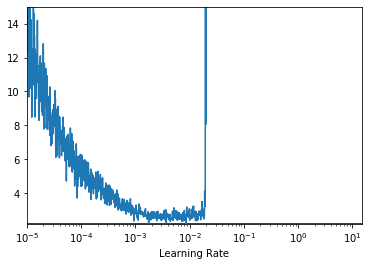

In [6]:
import tensorflow as tf
from tensorflow import keras
model2=tf.keras.models.clone_model(model1)
model2.compile(optimizer=opt,loss=loss_def,metrics=['accuracy'])
K=tf.keras.backend

class explr(keras.callbacks.Callback):
    def __init__(self,factor):
        self.factor=factor
        self.rates=[]
        self.losses=[]
    
    def on_batch_end(self,batch,logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs['loss'])
        K.set_value(self.model.optimizer.lr,self.model.optimizer.lr*self.factor)
    

def lr_finder(model,x,y,epochs=1,batch_size=32,min_rate=1e-5,max_rate=10):
    import numpy as np
    init_w=model.get_weights()
    init_lr=K.get_value(model.optimizer.lr)
    iterations=len(x)//batch_size*epochs
    factor=np.exp(np.log(max_rate/min_rate)/iterations)
    K.set_value(model.optimizer.lr,min_rate)
   
    
    exp_lr=explr(factor)
    model.fit(x,y,epochs=epochs,batch_size=batch_size,callbacks=[exp_lr])
    model.set_weights(init_w)
    K.set_value(model.optimizer.lr,init_lr)
    rates=exp_lr.rates
    losses=exp_lr.losses
   
    
    import matplotlib.pyplot as plt
    plt.plot(rates,losses)
    plt.gca().set_xscale("log")
    plt.hlines(min(losses),min(rates),max(rates))
    plt.axis([min(rates),max(rates),min(losses),15])
    plt.xlabel("Learning Rate")
    

lr_finder(model2,x_train,y_train,epochs=1,batch_size=32,min_rate=1e-5,max_rate=15)

In [7]:
escb=tensorflow.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=10,verbose=2,restore_best_weights=True)
history=model1.fit(initial_epoch=0,x=x_train,y=y_train,epochs=ep,validation_data=(x_val,y_val),batch_size=32,callbacks=[escb])#

Train on 40000 samples, validate on 10000 samples
Epoch 1/500
40000/40000 [==============================] - 25s 625us/sample - loss: 2.7940 - accuracy: 0.1160 - val_loss: 2.4506 - val_accuracy: 0.1346
Epoch 2/500
40000/40000 [==============================] - 27s 675us/sample - loss: 2.3413 - accuracy: 0.1537 - val_loss: 2.2730 - val_accuracy: 0.1573
Epoch 3/500
40000/40000 [==============================] - 26s 655us/sample - loss: 2.2089 - accuracy: 0.1710 - val_loss: 2.1582 - val_accuracy: 0.1820
Epoch 4/500
40000/40000 [==============================] - 26s 655us/sample - loss: 2.0871 - accuracy: 0.2090 - val_loss: 2.0480 - val_accuracy: 0.2175
Epoch 5/500
40000/40000 [==============================] - 26s 657us/sample - loss: 1.9876 - accuracy: 0.2443 - val_loss: 1.9670 - val_accuracy: 0.2554
Epoch 6/500
40000/40000 [==============================] - 26s 659us/sample - loss: 1.9182 - accuracy: 0.2709 - val_loss: 1.9050 - val_accuracy: 0.2858
Epoch 7/500
40000/40000 [=============

40000/40000 [==============================] - 26s 658us/sample - loss: 0.8942 - accuracy: 0.6929 - val_loss: 1.6831 - val_accuracy: 0.4957
Epoch 55/500
40000/40000 [==============================] - 26s 657us/sample - loss: 0.8798 - accuracy: 0.6956 - val_loss: 1.6601 - val_accuracy: 0.5017
Epoch 56/500
40000/40000 [==============================] - 26s 655us/sample - loss: 0.9440 - accuracy: 0.6768 - val_loss: 1.6578 - val_accuracy: 0.4963
Epoch 57/500
40000/40000 [==============================] - 26s 657us/sample - loss: 0.8808 - accuracy: 0.6941 - val_loss: 1.6695 - val_accuracy: 0.4995
Epoch 58/500
40000/40000 [==============================] - 26s 661us/sample - loss: 0.8539 - accuracy: 0.7062 - val_loss: 1.6965 - val_accuracy: 0.4916
Epoch 59/500
40000/40000 [==============================] - 27s 674us/sample - loss: 0.8493 - accuracy: 0.7065 - val_loss: 1.6583 - val_accuracy: 0.4977
Epoch 60/500
40000/40000 [==============================] - 27s 668us/sample - loss: 0.8405 - a

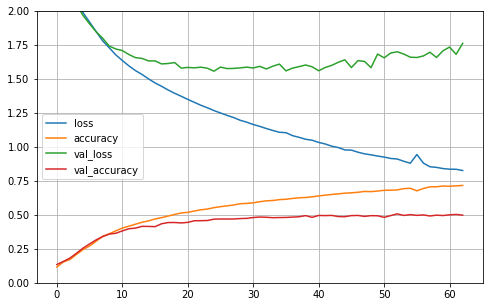

In [8]:
keras_plotter(history)

In [9]:
import numpy as np
y_pred=model1.predict(x_train)
y_pred_sparse=np.argmax(y_pred,axis=1)
y_train_sparse=np.argmax(y_train,axis=1)
from sklearn.metrics import accuracy_score
acc=accuracy_score(y_train_sparse,y_pred_sparse)
print("Train Accuracy",acc)

Train Accuracy 0.704


In [10]:
import numpy as np
y_pred=model1.predict(x_val)
y_pred_sparse=np.argmax(y_pred,axis=1)
y_val_sparse=np.argmax(y_val,axis=1)
from sklearn.metrics import accuracy_score
acc=accuracy_score(y_val_sparse,y_pred_sparse)
print("Validation Loss",acc)

Validation Loss 0.5024


In [11]:
import numpy as np
y_pred=model1.predict(x_test)
y_pred_sparse=np.argmax(y_pred,axis=1)
y_test_sparse=np.argmax(y_test,axis=1)
from sklearn.metrics import accuracy_score
acc=accuracy_score(y_test_sparse,y_pred_sparse)
print("Test Accuracy",acc)

Test Accuracy 0.4997


In [12]:
def mc_droupout(model1,x_test,y_test):
    
    num_iter=100
    print("test")
    y_prob_pred_temp=np.zeros((10000,10,num_iter))

    for i in range(num_iter):

        y_prob_pred_temp[:,:,i]=model1.predict(x_test)

    y_prob_pred=y_prob_pred_temp.mean(axis=2)
    y_prob_pred_sparse=np.argmax(y_prob_pred,axis=1)
    return y_prob_pred_sparse

y_prob_pred_sparse=mc_droupout(model1,x_test,y_test)
y_test_sparse=np.argmax(y_test,axis=1)
    
from sklearn.metrics import accuracy_score
acc=accuracy_score(y_test_sparse,y_prob_pred_sparse)
print("MC Dropout Test Loss",acc)


test
MC Dropout Test Loss 0.5369
